# Computing Turner Angle

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce
from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid

In [12]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_high_res_1.nc')

In [9]:
Tu, Rrho, pmid = gsw.stability.Turner_Rsubrho(ds.SA, ds.CT, ds.PRES, axis=1)

In [27]:
ds_Tu = xr.Dataset(data_vars=dict(Tu=(['N_PROF','PRES_INTERPOLATED'], Tu),
                                  LATITUDE=(['N_PROF'], ds.LATITUDE.values),
                                  LONGITUDE=(['N_PROF'], ds.LONGITUDE.values)),
                   coords=dict(N_PROF=(['N_PROF'],ds.N_PROF.values),
                               PRES_INTERPOLATED=(['PRES_INTERPOLATED'],ds.PRES_INTERPOLATED.isel(PRES_INTERPOLATED=slice(1,None)).values)))

In [28]:
ds_Tu

<xarray.Dataset> Size: 12GB
Dimensions:            (N_PROF: 1488063, PRES_INTERPOLATED: 1000)
Coordinates:
  * N_PROF             (N_PROF) int64 12MB 2428701 1114461 ... 1502504 411205
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 2 4 6 8 ... 1996 1998 2000
Data variables:
    Tu                 (N_PROF, PRES_INTERPOLATED) float64 12GB nan nan ... nan
    LATITUDE           (N_PROF) float64 12MB -78.16 -78.15 ... 89.77 89.78
    LONGITUDE          (N_PROF) float64 12MB -174.6 -161.6 ... -99.35 139.1

In [29]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

def get_ds_rho(ds_z, da_SIG0, rho_grid, variables, dim1='N_PROF', dim2='PRES_INTERPOLATED'):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG0, ds_z[var],
            input_core_dims=[['PRES_INTERPOLATED'], ['PRES_INTERPOLATED']],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[ds_z[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=['N_PROF', 'rho_grid'],
            coords={'rho_grid': rho_grid, 'N_PROF': ds_z.N_PROF},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')
    #ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    ds_rho = ds_rho.assign_coords(LATITUDE  =(dim1, ds_z.LATITUDE.data))
    ds_rho = ds_rho.assign_coords(LONGITUDE =(dim1, ds_z.LONGITUDE.data))
    
    return ds_rho

In [30]:
rho_grid = np.arange(21,29,0.0025)
lon_bins = np.arange(-180,181,3)
lat_bins = np.arange(-88.5,89,3)

In [31]:
%%time
Tu_rho = get_ds_rho(ds_Tu, ds.SIG0.isel(PRES_INTERPOLATED=slice(1,None)), rho_grid, ['Tu'])

Completed comp for Tu
Completed Tu
Completed merge
CPU times: user 13min 22s, sys: 1min 6s, total: 14min 29s
Wall time: 14min 29s


In [32]:
Tu_rho

<xarray.Dataset> Size: 38GB
Dimensions:    (rho_grid: 3200, N_PROF: 1488063)
Coordinates:
  * rho_grid   (rho_grid) float64 26kB 21.0 21.0 21.01 21.01 ... 28.99 29.0 29.0
  * N_PROF     (N_PROF) int64 12MB 2428701 1114461 2155018 ... 1502504 411205
    LATITUDE   (N_PROF) float64 12MB -78.16 -78.15 -78.15 ... 89.75 89.77 89.78
    LONGITUDE  (N_PROF) float64 12MB -174.6 -161.6 -175.1 ... -99.35 139.1
Data variables:
    Tu         (N_PROF, rho_grid) float64 38GB nan nan nan nan ... nan nan nan

In [41]:
Tu_rho.to_netcdf('/swot/SUM05/amf2288/var-boxes/Tu_rho.nc')

In [56]:
def classify_Tu(ds, var='Tu', new_var='Tu_int'):
    """Classify Tu angles into integer bins with NaNs preserved.

    -1 → −90 < Tu < −45
     0 → −45 ≤ Tu < 45
     1 →  45 ≤ Tu < 90
     2 → Tu ≤ −90 or Tu ≥ 90
     NaN → Tu is NaN
    """
    Tu = ds[var]

    Tu_int = xr.where(Tu.isnull(), np.nan,                # preserve NaNs
              xr.where((Tu <= -90) | (Tu >= 90), 2,
              xr.where(Tu < -45, -1,
              xr.where(Tu < 45, 0,
              xr.where(Tu < 90, 1, np.nan)))))            # default fallback NaN

    Tu_int.name = new_var
    return Tu_int


In [57]:
%%time
Tu_rho['Tu_int'] = classify_Tu(Tu_rho)

CPU times: user 1min 38s, sys: 2min 36s, total: 4min 15s
Wall time: 4min 15s


In [74]:
Tu_rho

<xarray.Dataset> Size: 76GB
Dimensions:    (rho_grid: 3200, N_PROF: 1488063)
Coordinates:
  * rho_grid   (rho_grid) float64 26kB 21.0 21.0 21.01 21.01 ... 28.99 29.0 29.0
  * N_PROF     (N_PROF) int64 12MB 2428701 1114461 2155018 ... 1502504 411205
    LATITUDE   (N_PROF) float64 12MB -78.16 -78.15 -78.15 ... 89.75 89.77 89.78
    LONGITUDE  (N_PROF) float64 12MB -174.6 -161.6 -175.1 ... -99.35 139.1
Data variables:
    Tu         (N_PROF, rho_grid) float64 38GB nan nan nan nan ... nan nan nan
    Tu_int     (N_PROF, rho_grid) float64 38GB nan nan nan nan ... nan nan nan

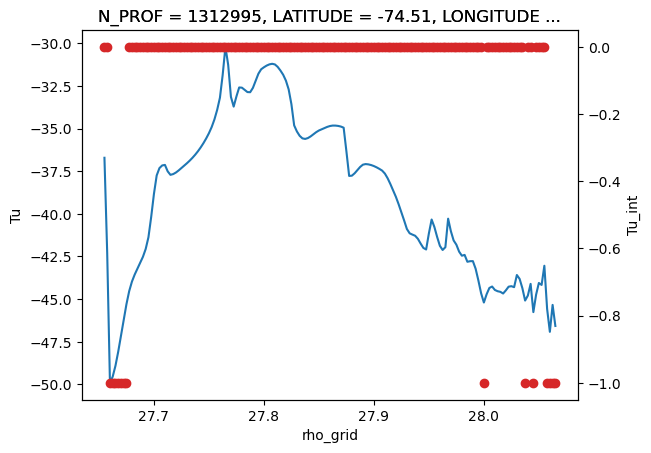

In [73]:
Tu_rho.isel(N_PROF=1000).Tu.plot()
plt.twinx()
Tu_rho.isel(N_PROF=1000).Tu_int.plot.scatter(color='tab:red')

In [77]:
def get_ds_gridded(ds, lon_bins, lat_bins, func='mean'):
    # Step 1: Reduce using flox
    ds_binned = xarray_reduce(
        ds,
        'LONGITUDE',
        'LATITUDE',
        func=func,
        expected_groups=(
            pd.IntervalIndex.from_breaks(lon_bins),
            pd.IntervalIndex.from_breaks(lat_bins)
        ),
        fill_value=np.nan,
        skipna=True
    )

    # Step 2: Rename dimensions and variables
    ds_binned = ds_binned.rename_dims({
        'LONGITUDE_bins': 'lon',
        'LATITUDE_bins': 'lat',
        'rho_grid': 'density'
    }).rename_vars({
        'LONGITUDE_bins': 'lon',
        'LATITUDE_bins': 'lat',
        'rho_grid': 'density'
    })

    # Step 3: Replace Interval coordinates with midpoints
    def interval_midpoints(intervals):
        return np.array([interval.mid for interval in intervals])

    ds_binned = ds_binned.assign_coords({
        'lon': ('lon', interval_midpoints(ds_binned['lon'].values)),
        'lat': ('lat', interval_midpoints(ds_binned['lat'].values))
    })

    # Step 4: Generate grid and xgcm object
    ds_gridded = generate_grid_ds(ds_binned, {'X': 'lon', 'Y': 'lat'})
    grid = Grid(ds_gridded, coords={
        'X': {'center': 'lon', 'left': 'lon_left'},
        'Y': {'center': 'lat', 'left': 'lat_left'},
        'Z': {'center': 'density'}
    }, periodic=['X'])

    return ds_gridded, grid

In [78]:
Tu_rho_mean, Tu_rho_grid = get_ds_gridded(Tu_rho, lon_bins, lat_bins, func='mean')

In [79]:
Tu_rho_mean

<xarray.Dataset> Size: 363MB
Dimensions:   (density: 3200, lon: 120, lat: 59, lon_left: 120, lat_left: 59)
Coordinates:
  * density   (density) float64 26kB 21.0 21.0 21.01 21.01 ... 28.99 29.0 29.0
  * lon       (lon) float64 960B -178.5 -175.5 -172.5 ... 172.5 175.5 178.5
  * lat       (lat) float64 472B -87.0 -84.0 -81.0 -78.0 ... 78.0 81.0 84.0 87.0
  * lon_left  (lon_left) float64 960B -180.0 -177.0 -174.0 ... 171.0 174.0 177.0
  * lat_left  (lat_left) float64 472B -88.5 -85.5 -82.5 -79.5 ... 79.5 82.5 85.5
Data variables:
    Tu        (density, lon, lat) float64 181MB nan nan nan nan ... nan nan nan
    Tu_int    (density, lon, lat) float64 181MB nan nan nan nan ... nan nan nan

In [ ]:
Tu_rho_mode, Tu_rho, grid = get_ds_gridded(Tu_rho, lon_bins, lat_bins, func='mode')

In [ ]:
Tu_rho_mode

In [ ]:
density = 27.5
ds = Tu_rho_mean.Tu

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), robust=True)
plt.title(f'MEAN Tu, density={density}m')

In [ ]:
density = 27.5
ds = Tu_rho_mode.Tu_int

fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds.sel(density=density, method='nearest').plot(x='lon',y='lat',ax=ax,transform=ccrs.PlateCarree(), robust=True)
plt.title(f'MODE Tu, density={density}m')